In [1]:
# Common imports
import numpy as np
import os
import optuna

c:\Users\raul\.conda\envs\noestructurados\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
##########  Using gym
import gymnasium as gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
N_episodios = 250
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

from collections import deque

replay_memory = deque(maxlen=2000)

In [8]:
# Let's build the DQN. 
# Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after 
# it plays that action (but before it sees its outcome):
class DDQN():
    def __init__(self,batch_size= 32, discount_rate=0.5,loss_fn = keras.losses.mean_squared_error,learning_rate=1e-2):
        self.best_score = 0
        self.batch_size = batch_size
        self.discount_rate = discount_rate
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = loss_fn



        self.model = keras.models.Sequential([
        keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        keras.layers.Dense(256, activation="elu"),
        keras.layers.Dense(1024, activation="elu"),
        keras.layers.Dense(256, activation="elu"),
        keras.layers.Dense(64, activation="elu"),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Flatten(),
        keras.layers.Dense(n_outputs)
    ])

        self.target = keras.models.clone_model(self.model)  # NEW It is a clone of the online model
        self.target.set_weights(self.model.get_weights())   # NEW
        
    def epsilon_greedy_policy(self,state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(n_outputs)
        else:
            Q_values = self.model.predict(state[np.newaxis])
            #print("Q_values", Q_values)
            return np.argmax(Q_values)
        
    def play_one_step(self,env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        return next_state, reward, done, info
    
    def sample_experiences(self,batch_size):
        indices = np.random.randint(len(replay_memory), size=batch_size)
        batch = [replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones
    
    def training_step(self,batch_size):
        
        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones = experiences
        #next_Q_values = model.predict(next_states)  # ORIGINAL DQN
        next_Q_values = self.target.predict(next_states)  # NEW  Using the target model instead the online model 
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = (rewards +
                        (1 - dones) * self.discount_rate * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)   # Use of the online model
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    def predict(self,obs):
        return self.model.predict(obs)
    def train(self):
        self.rewards = []
        
        for episode in range(N_episodios):
            obs = env.reset() 
            obs = obs[0]
            print("Se resetea")
            for step in range(200):
                epsilon = max(1 - episode / 500, 0.01)
                obs, reward, done, info = self.play_one_step(env, obs, epsilon)
                if done:
                    break
            self.rewards.append(step) # Not shown in the book
            if step >= self.best_score: # Not shown
                best_weights = self.model.get_weights() # Not shown
                self.best_score = step # Not shown
            print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
            #print(" Episodio vvvv", episode)
            if episode > 50:
                #print(" batch size vvvv", batch_size)      
                self.training_step(self.batch_size)
            if episode % 50 == 0:     ## Updating weights
                self.target.set_weights(self.model.get_weights())

        self.model.set_weights(best_weights)

log_dir = os.path.join(os.getcwd(),'logsDDQN')

env = gym.make("ALE/AirRaid-v5",render_mode="rgb_array")
env = Monitor(env, log_dir)

input_shape =env.observation_space.shape
n_outputs = env.action_space.n



In [5]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [6]:
def objective(trial):
    # Define los rangos para los parámetros que quieres optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    discount_rate = trial.suggest_uniform('discount_rate', 0.1, 0.90)

    ddqn =DDQN(batch_size=batch_size,discount_rate=discount_rate,learning_rate=learning_rate)
    # Define el callback para guardar el mejor modelo
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
    return ddqn.best_score

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)

print("Params: ")

[I 2024-05-08 16:33:40,842] A new study created in memory with name: no-name-5403bd0b-5d35-4eee-b30a-e816bd3675b7
C:\Users\raul\AppData\Local\Temp\ipykernel_8148\3071801666.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\raul\AppData\Local\Temp\ipykernel_8148\3071801666.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  discount_rate = trial.suggest_uniform('discount_rate', 0.1, 0.90)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 250, 160, 32)      128       
                                                                 
 dense_8 (Dense)             (None, 250, 160, 256)     8448      
                                                                 
 dense_9 (Dense)             (None, 250, 160, 1024)    263168    
                                                                 
 dense_10 (Dense)            (None, 250, 160, 256)     262400    
                                                                 
 dense_11 (Dense)            (None, 250, 160, 64)      16448     
                                                                 
 dense_12 (Dense)            (None, 250, 160, 32)      2080      
                                                                 
 flatten_1 (Flatten)         (None, 1280000)          

[I 2024-05-08 16:33:41,579] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0001183535643047837, 'batch_size': 128, 'discount_rate': 0.25118662932468433}. Best is trial 0 with value: 0.0.


None
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 250, 160, 32)      128       
                                                                 
 dense_15 (Dense)            (None, 250, 160, 256)     8448      
                                                                 
 dense_16 (Dense)            (None, 250, 160, 1024)    263168    
                                                                 
 dense_17 (Dense)            (None, 250, 160, 256)     262400    
                                                                 
 dense_18 (Dense)            (None, 250, 160, 64)      16448     
                                                                 
 dense_19 (Dense)            (None, 250, 160, 32)      2080      
                                                                 
 flatten_2 (Flatten)         (None, 1280000)     

[I 2024-05-08 16:33:42,280] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.5604953595925908e-05, 'batch_size': 64, 'discount_rate': 0.3694100778182231}. Best is trial 0 with value: 0.0.


None
Best trial:
Value:  0.0
Params: 


Con el mejor intento, lo entreno y saco los rewards

In [10]:
trial.be

{'learning_rate': 0.0001183535643047837,
 'batch_size': 128,
 'discount_rate': 0.25118662932468433}

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 250, 160, 32)      128       
                                                                 
 dense_29 (Dense)            (None, 250, 160, 256)     8448      
                                                                 
 dense_30 (Dense)            (None, 250, 160, 1024)    263168    
                                                                 
 dense_31 (Dense)            (None, 250, 160, 256)     262400    
                                                                 
 dense_32 (Dense)            (None, 250, 160, 64)      16448     
                                                                 
 dense_33 (Dense)            (None, 250, 160, 32)      2080      
                                                                 
 flatten_4 (Flatten)         (None, 1280000)          

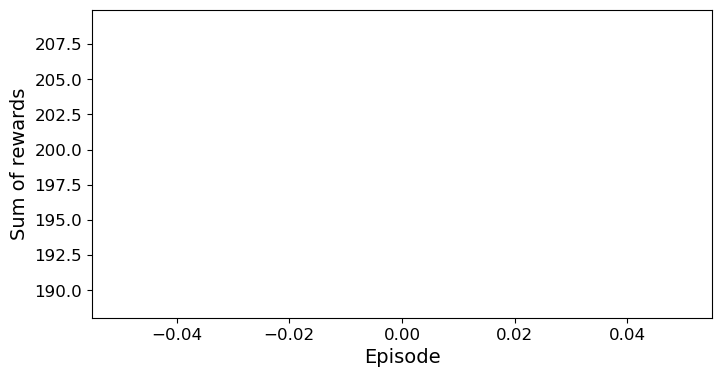

In [12]:
ddqn =DDQN(batch_size=trial.params['batch_size'],discount_rate=trial.params['discount_rate'],learning_rate=trial.params['learning_rate'])
ddqn.train()
plt.figure(figsize=(8, 4))
plt.plot(ddqn.rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = "ALE/AirRaid-v5"
directorio_video = os.path.join(os.getcwd(),'videosDDQN')

longitud = 1819
 
vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
 
obs = vec_env.reset()
 
# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, directorio_video,
                       record_video_trigger=lambda x: x == 0, video_length=longitud,
                       name_prefix=f"agent")
vec_env.reset()
for _ in range(longitud + 1):
  action, _states = ddqn.predict(obs)
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()